In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt

os.environ['TEJAPI_KEY'] = "Your Key"
os.environ['TEJAPI_BASE'] = "https://api.tej.com.tw"

In [2]:
from zipline.data import bundles
from zipline.api import *
from zipline.finance import commission, slippage
from zipline import run_algorithm
from zipline.utils.calendar_utils import get_calendar
from zipline.pipeline import *
from zipline.TQresearch.tej_pipeline import run_pipeline
from zipline.pipeline.filters import StaticAssets
from zipline.pipeline.data import TWEquityPricing
import pyfolio as pf
from pyfolio.utils import extract_rets_pos_txn_from_zipline

In [3]:
import TejToolAPI
from zipline.sources.TEJ_Api_Data import get_universe

# Get all stock of TWSE & OTC 
pool = get_universe(start = '2010-01-01', 
                    end = '2023-12-29',
                    mkt = ['TWSE', 'OTC'],
                    stktp_e=['Common Stock-Foreign', 'Common Stock']
                    )

# "d0001" is the column of monthly revenue
columns = ["d0001"]
data = TejToolAPI.get_history_data(
    ticker = pool,
    columns = columns,
    transfer_to_chinese = True,
    start = pd.Timestamp("2010-01-01"),
    end = pd.Timestamp("2023-12-29"),
)

Currently used TEJ API key call quota 272/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 38350469/9223372036854775807 (0.0%)
Currently used TEJ API key call quota 386/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 48361578/9223372036854775807 (0.0%)


In [6]:
from logbook import Logger, StderrHandler, INFO
# Use logbook to log messages
log_handler = StderrHandler(format_string='[{record.time:%Y-%m-%d %H:%M:%S.%f}]: ' +
                            '{record.level_name}: {record.func_name}: {record.message}',
                            level=INFO)
log_handler.push_application()
log = Logger('get_universe')

# Set the interval of backtesting
start = '2010-01-01'
end = '2023-12-29'
os.environ['mdate'] = start + ' ' + end
os.environ['ticker'] = ' '.join(pool) + ' ' + 'IR0001'

# Ingest data to tquant
!zipline ingest -b tquant

[2024-09-05 05:26:57.066000] INFO: zipline.data.bundles.core: Ingesting tquant.
Merging daily equity files:  [####################################]      
Currently used TEJ API key call quota 402/9223372036854775807 (0.0%)
Currently used TEJ API key data quota 60964860/9223372036854775807 (0.0%)
[2024-09-05 05:32:34.569975] INFO: zipline.data.bundles.core: Ingest tquant successfully.


In [7]:
# Rename each column.
data.rename(columns={'股票代碼':'coid', '日期':'mdate', '單月營收_千元':'revenue'}, inplace=True)

# Sort the data based on `coid` and `mdate` to ensure the correct chronological order.
data.sort_values(by=['coid', 'mdate'], inplace=True)

# Convert the data into a quarterly format and add a `period` column to represent the quarter for each data entry.
data['period'] = data['mdate'].dt.to_period('Q')

# For each stock, calculate the average monthly revenue for each quarter by summing the monthly revenues within the quarter, then store the result in the `season_revenue` column.
data['season_revenue'] = data.groupby(['coid', 'period'])['revenue'].transform('mean')

# data type of each column.
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5448725 entries, 0 to 5448724
Data columns (total 5 columns):
 #   Column          Dtype         
---  ------          -----         
 0   coid            object        
 1   mdate           datetime64[ns]
 2   revenue         float64       
 3   period          period[Q-DEC] 
 4   season_revenue  float64       
dtypes: datetime64[ns](1), float64(2), object(1), period[Q-DEC](1)
memory usage: 249.4+ MB


In [8]:
from zipline.data import bundles
# Load the Zipline data bundle and specify the bundle name as 'tquant'.
bundle_name = 'tquant'
bundle = bundles.load(bundle_name)

from zipline.pipeline.data.dataset import Column, DataSet
from zipline.pipeline.domain import TW_EQUITIES

class CustomDataset(DataSet):
    # Define a floating point number field to store quarterly revenue
    season_revenue = Column(float)
    domain = TW_EQUITIES

# Create a mapping between each stock's symbol and its sid.
sids = bundle.asset_finder.equities_sids
assets = bundle.asset_finder.retrieve_all(sids)
symbol_mapping_sid = {i.symbol:i.sid for i in assets}

In [9]:
# Convert a DataFrame into a pipeline format
transform_data = data.set_index(['coid', 'mdate']).unstack('coid')
transform_data = transform_data.rename(columns = symbol_mapping_sid)
transform_data.index = transform_data.index.tz_localize('UTC')
transform_data

revenue                                      \
coid                            0          1         2         3    4      
mdate                                                                      
2010-01-04 00:00:00+00:00        NaN        NaN       NaN       NaN  NaN   
2010-01-05 00:00:00+00:00        NaN        NaN       NaN       NaN  NaN   
2010-01-06 00:00:00+00:00        NaN        NaN       NaN       NaN  NaN   
2010-01-07 00:00:00+00:00        NaN        NaN       NaN       NaN  NaN   
2010-01-08 00:00:00+00:00        NaN        NaN       NaN       NaN  NaN   
...                              ...        ...       ...       ...  ...   
2023-12-25 00:00:00+00:00  8786909.0  6915817.0  255428.0  777614.0  NaN   
2023-12-26 00:00:00+00:00  8786909.0  6915817.0  255428.0  777614.0  NaN   
2023-12-27 00:00:00+00:00  8786909.0  6915817.0  255428.0  777614.0  NaN   
2023-12-28 00:00:00+00:00  8786909.0  6915817.0  255428.0  777614.0  NaN   
2023-12-29 00:00:00+00:00  8786909.0  6915817.0  255428.0  777614.0  NaN   

                                                                              \
coid                           5         6         7          8         9      
mdate                                                                          
2010-01-04 00:00:00+00:00       NaN       NaN       NaN        NaN       NaN   
2010-01-05 00:00:00+00:00       NaN       NaN       NaN        NaN       NaN   
2010-01-06 00:00:00+00:00       NaN       NaN       NaN        NaN       NaN   
2010-01-07 00:00:00+00:00       NaN       NaN       NaN        NaN       NaN   
2010-01-08 00:00:00+00:00       NaN       NaN       NaN        NaN       NaN   
...                             ...       ...       ...        ...       ...   
2023-12-25 00:00:00+00:00  503715.0  532975.0  229619.0  1854759.0  565727.0   
2023-12-26 00:00:00+00:00  503715.0  532975.0  229619.0  1854759.0  565727.0   
2023-12-27 00:00:00+00:00  503715.0  532975.0  229619.0  1854759.0  565727.0   
2023-12-28 00:00:00+00:00  503715.0  532975.0  229619.0  1854759.0  565727.0   
2023-12-29 00:00:00+00:00  503715.0  532975.0  229619.0  1854759.0  565727.0   

                           ... season_revenue                              \
coid                       ...           1977          1978          1979   
mdate                      ...                                              
2010-01-04 00:00:00+00:00  ...            NaN           NaN           NaN   
2010-01-05 00:00:00+00:00  ...            NaN           NaN           NaN   
2010-01-06 00:00:00+00:00  ...            NaN           NaN           NaN   
2010-01-07 00:00:00+00:00  ...            NaN           NaN           NaN   
2010-01-08 00:00:00+00:00  ...            NaN           NaN           NaN   
...                        ...            ...           ...           ...   
2023-12-25 00:00:00+00:00  ...  145916.761905  2.430769e+06  89055.920635   
2023-12-26 00:00:00+00:00  ...  145916.761905  2.430769e+06  89055.920635   
2023-12-27 00:00:00+00:00  ...  145916.761905  2.430769e+06  89055.920635   
2023-12-28 00:00:00+00:00  ...  145916.761905  2.430769e+06  89055.920635   
2023-12-29 00:00:00+00:00  ...  145916.761905  2.430769e+06  89055.920635   

                                                                       \
coid                               1980           1981           1982   
mdate                                                                   
2010-01-04 00:00:00+00:00           NaN            NaN            NaN   
2010-01-05 00:00:00+00:00           NaN            NaN            NaN   
2010-01-06 00:00:00+00:00           NaN            NaN            NaN   
2010-01-07 00:00:00+00:00           NaN            NaN            NaN   
2010-01-08 00:00:00+00:00           NaN            NaN            NaN   
...                                 ...            ...            ...   
2023-12-25 00:00:00+00:00  15065.285714  241996.365079  489094.634921   
2023-12-26 00:00:00+00:00  15065.2

In [10]:
from zipline.pipeline import SimplePipelineEngine
from zipline.pipeline.data import TWEquityPricing
from zipline.pipeline.loaders import EquityPricingLoader
from zipline.pipeline.loaders.frame import DataFrameLoader

custom_loader = {}
inputs = [CustomDataset.season_revenue]

# Place the custom dataset and the transformed data into the custom_loader.
for i in inputs:
    custom_loader[i] = DataFrameLoader(column=i, baseline=transform_data[i.name])

# Using a bundle stock daily data reader and an adjustment reader.
pricing_loader = EquityPricingLoader.without_fx(bundle.equity_daily_bar_reader,
                                                bundle.adjustment_reader)

# Define the choose_loader function to select the appropriate data loader based on the column name.
def choose_loader(column):
    if column.name in TWEquityPricing._column_names:
        return pricing_loader
    elif column.name in CustomDataset._column_names:     
        return custom_loader[column]
    else:
        raise Exception('Column not available')

# Create an instance of SimplePipelineEngine
engine = SimplePipelineEngine(get_loader = choose_loader,
                                asset_finder = bundle.asset_finder,
                                default_domain = TW_EQUITIES)

In [11]:
from zipline.pipeline.filters import StaticAssets

# Importing the StaticAssets filter to create a custom asset mask that excludes a specific benchmark asset.
assets_ex_IR0001 = [i for i in assets if i != bundle.asset_finder.lookup_symbol('IR0001', as_of_date=None)]
benchmark_asset = bundle.asset_finder.lookup_symbol('IR0001',as_of_date = None)

def make_pipeline():
    
    # Get the season revenue column from the CustomDataset.
    seanson_revenue = CustomDataset.season_revenue.latest

    # To filter out stocks with revenue in the top and bottom 20% while excluding the specific asset 'IR0001'.
    top_20_decile = seanson_revenue.percentile_between(80, 100, mask=StaticAssets(assets_ex_IR0001))
    bottom_20_decile = seanson_revenue.percentile_between(0, 20, mask=StaticAssets(assets_ex_IR0001))

    # Return value of pipeline column
    my_pipeline = Pipeline(
        columns = {
            'curr_price': TWEquityPricing.close.latest,
            'season_revenue': seanson_revenue,
            'longs': top_20_decile,
            'shorts': bottom_20_decile
        },
        screen = ~StaticAssets([benchmark_asset])
    )
    return my_pipeline

# Redefine the start and end dates for the backtesting period.
start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')
my_pipeline = engine.run_pipeline(make_pipeline(), start_dt, end_dt)
my_pipeline 

curr_price  season_revenue  \
2010-01-05 00:00:00+00:00 Equity(0 [1101])          34.30             NaN   
                          Equity(1 [1102])          34.55             NaN   
                          Equity(2 [1103])          18.40             NaN   
                          Equity(3 [1104])          18.40             NaN   
                          Equity(4 [1107])           0.95             NaN   
...                                                   ...             ...   
2023-12-29 00:00:00+00:00 Equity(1982 [9951])       76.30    4.890946e+05   
                          Equity(1983 [9955])       24.50    9.181279e+04   
                          Equity(1984 [9958])      173.50    1.334906e+06   
                          Equity(1985 [9960])       27.30    8.044881e+04   
                          Equity(1986 [9962])       18.25    2.686607e+05   

                                               longs  shorts  
2010-01-05 00:00:00+00:00 Equity(0 [1101])     False   False  
                          Equity(1 [1102])     False   False  
                          Equity(2 [1103])     False   False  
                          Equity(3 [1104])     False   False  
                          Equity(4 [1107])     False   False  
...                                              ...     ...  
2023-12-29 00:00:00+00:00 Equity(1982 [9951])  False   False  
                          Equity(1983 [9955])  False   False  
                          Equity(1984 [9958])   True   False  
                          Equity(1985 [9960])  False   False  
                          Equity(1986 [9962])  False   False  

[5451368 rows x 4 columns]

In [12]:
from zipline.utils.calendar_utils import get_calendar

# Get the trading day for the 'TEJ' calendar between the interval of backtesting
cal = get_calendar('TEJ').all_sessions
cal = cal[(cal >= start) & (cal <= end)]
cal[-10:]

DatetimeIndex(['2023-12-18 00:00:00+00:00', '2023-12-19 00:00:00+00:00',
               '2023-12-20 00:00:00+00:00', '2023-12-21 00:00:00+00:00',
               '2023-12-22 00:00:00+00:00', '2023-12-25 00:00:00+00:00',
               '2023-12-26 00:00:00+00:00', '2023-12-27 00:00:00+00:00',
               '2023-12-28 00:00:00+00:00', '2023-12-29 00:00:00+00:00'],
              dtype='datetime64[ns, UTC]', freq='C')

In [19]:
# Convert the dates into a DataFrame and calculate the difference between each date and the midpoint of the season.
cal = pd.DataFrame(cal).rename(columns={0: 'date'})
cal['diff'] = cal['date'].transform(lambda x: x - pd.Timestamp(year=x.year, month=(x.month - 1) // 3 * 3 + 2, day=15, tz='UTC'))

# Change the grouping to be based on year and quarter.
tradeday = cal.groupby([cal['date'].dt.year, cal['date'].dt.quarter]).apply(lambda x: x[x['diff'].ge(pd.Timedelta(days=0))].head(1)).date.tolist()

# Convert the trading days to string format.
tradeday = [str(i.date()) for i in tradeday]

tradeday[:12]

['2010-02-22',
 '2010-05-17',
 '2010-08-16',
 '2010-11-15',
 '2011-02-15',
 '2011-05-16',
 '2011-08-15',
 '2011-11-15',
 '2012-02-15',
 '2012-05-15',
 '2012-08-15',
 '2012-11-15']

In [ ]:
import matplotlib.pyplot as plt

def analyze(context, perf):
    fig = plt.figure(figsize=(16, 12))

    # First chart (Cumulative Return)
    ax = fig.add_subplot(311)
    ax.set_title('Strategy Results') 
    ax.plot(perf['algorithm_period_return'], linestyle='-', 
                label='algorithm period return', linewidth=3.0)
    ax.plot(perf['benchmark_period_return'], linestyle='-', 
                label='benchmark period return', linewidth=3.0)
    ax.legend()
    ax.grid(True)

    # Second chart (ending_cash) -> Observe whether it is overbought.
    ax = fig.add_subplot(312)
    ax.plot(perf['ending_cash'], 
                label='ending_cash', linestyle='-', linewidth=1.0)
    ax.axhline(y=1,c='r',linewidth=0.3)
    ax.legend()
    ax.grid(True)

[2024-09-05 05:42:49.447337]: INFO: earn_dividends: Equity(949 [3702]), cash_dividend amount: 1.999128, pay_date: 2010-09-24, div_owed: 326169.727968
[2024-09-05 05:42:49.448206]: INFO: handle_split: after split: asset: Equity(949 [3702]), amount: 192519, cost_basis: 46.61, last_sale_price: 73.4
[2024-09-05 05:42:49.448499]: INFO: handle_split: returning cash: 10.04
[2024-09-05 05:42:50.644626]: INFO: earn_dividends: Equity(946 [3697]), cash_dividend amount: 10.08, pay_date: 2011-08-31, div_owed: 187598.88
[2024-09-05 05:42:50.645429]: INFO: handle_split: after split: asset: Equity(946 [3697]), amount: 20489, cost_basis: 216.76, last_sale_price: 167.0
[2024-09-05 05:42:50.645728]: INFO: handle_split: returning cash: 215.44
[2024-09-05 05:42:51.293176]: INFO: handle_split: after split: asset: Equity(933 [3673]), amount: 5070, cost_basis: 510.47, last_sale_price: 881.0
[2024-09-05 05:42:51.293616]: INFO: handle_split: returning cash: 253.02
[2024-09-05 05:42:51.317048]: INFO: earn_divide

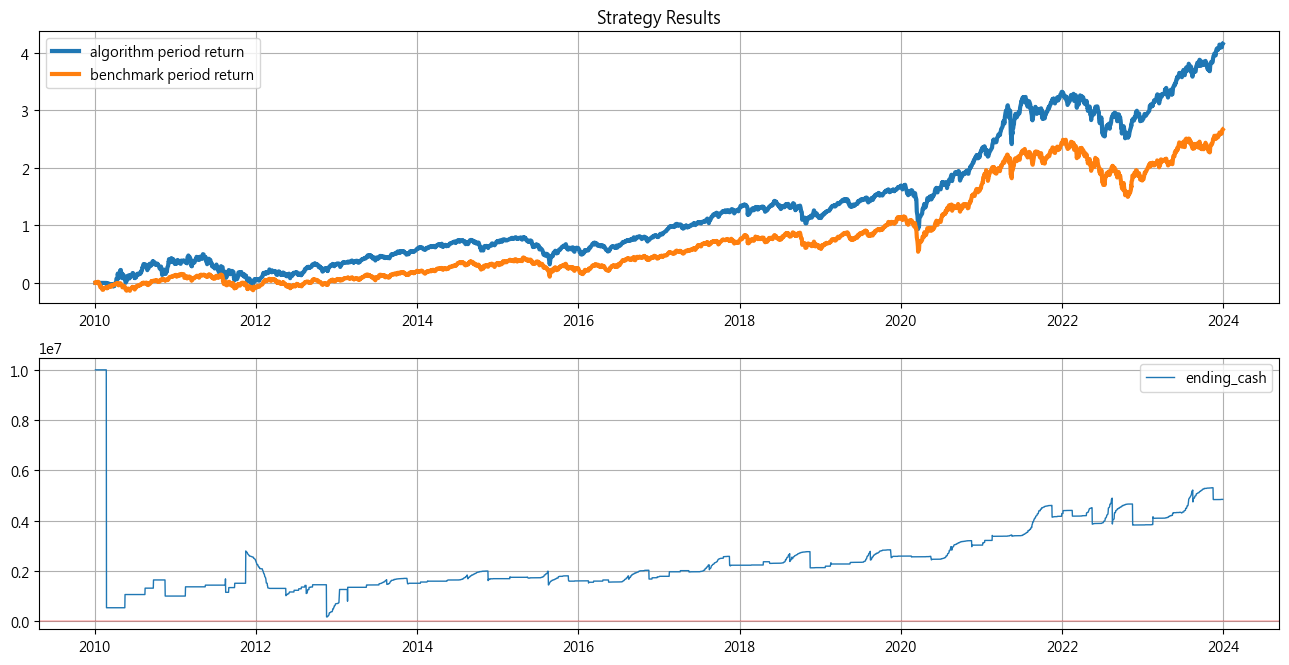

In [21]:
from zipline.algo.pipeline_algo import *

# Setting the start and end dates for the backtest
start_dt = pd.Timestamp(start, tz = 'UTC')
end_dt = pd.Timestamp(end, tz = 'UTC')

# Creating the Target Percent Pipeline Algorithm
algo = TargetPercentPipeAlgo(
                        start_session=start_dt, # Start time of the backtest
                        end_session=end_dt, # End time of the backtest
                        capital_base=1e7, # Initial capital set to 10 million        
                        tradeday=tradeday, # Trading day parameter
                        max_leverage=0.9, # Maximum leverage ratio of 0.9
                        pipeline=make_pipeline, # Use the data of pipeline 
                        slippage_model=slippage.VolumeShareSlippage(volume_limit=0.15, price_impact=0.01), # Slippage model
                        commission_model = commission.Custom_TW_Commission(min_trade_cost = 20, discount = 1.0, tax = 0.003), # Commission model for the Taiwan market
                        custom_loader=custom_loader, # Custom data loader for loading specific data
                        analyze=analyze, # analyze function
                        # allow_short=True # If you want to implement a short-selling strategy, you can set this parameter to true.
)

# Run backtesting
results = algo.run()

In [22]:
results

,period_open,period_close,ending_exposure,ending_cash,benchmark_return,long_value,treasury_return,orders,transactions,returns,...,treasury_period_return,algo_volatility,algorithm_period_return,period_label,trading_days,sharpe,max_drawdown,max_leverage,alpha,beta
2010-01-04 13:30:00+08:00,2010-01-04 09:01:00+08:00,2010-01-04 13:30:00+08:00,0.00,1.000000e+07,NaN,0.00,0.0,[],[],0.000000,...,0.0,NaN,0.000000,2010-01,1,NaN,0.000000,0.000000,NaN,NaN
2010-01-05 13:30:00+08:00,2010-01-05 09:01:00+08:00,2010-01-05 13:30:00+08:00,0.00,1.000000e+07,0.000433,0.00,0.0,[],[],0.000000,...,0.0,0.000000,0.000000,2010-01,2,NaN,0.000000,0.000000,NaN,NaN
2010-01-06 13:30:00+08:00,2010-01-06 09:01:00+08:00,2010-01-06 13:30:00+08:00,0.00,1.000000e+07,0.014153,0.00,0.0,[],[],0.000000,...,0.0,0.000000,0.000000,2010-01,3,NaN,0.000000,0.000000,0.000000,0.000000
2010-01-07 13:30:00+08:00,2010-01-07 09:01:00+08:00,2010-01-07 13:30:00+08:00,0.00,1.000000e+07,-0.010831,0.00,0.0,[],[],0.000000,...,0.0,0.000000,0.000000,2010-01,4,NaN,0.000000,0.000000,0.000000,0.000000
2010-01-08 13:30:00+08:00,2010-01-08 09:01:00+08:00,2010-01-08 13:30:00+08:00,0.00,1.000000e+07,0.005278,0.00,0.0,[],[],0.000000,...,0.0,0.000000,0.000000,2010-01,5,NaN,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-25 13:30:00+08:00,2023-12-25 09:01:00+08:00,2023-12-25 13:30:00+08:00,46150532.92,4.847998e+06,0.000466,46150532.92,0.0,[],[],-0.002206,...,0.0,0.173345,4.099853,2023-12,3435,0.776467,-0.353172,0.985907,0.045877,0.844797
2023-12-26 13:30:00+08:00,2023-12-26 09:01:00+08:00,2023-12-26 13:30:00+08:00,46511330.71,4.847998e+06,0.008348,46511330.71,0.0,[],[],0.007075,...,0.0,0.173329,4.135933,2023-12,3436,0.779307,-0.353172,0.985907,0.045866,0.844794
2023-12-27 13:30:00+08:00,2023-12-27 09:01:00+08:00,2023-12-27 13:30:00+08:00,46720250.19,4.847998e+06,0.007874,46720250.19,0.0,[],[],0.004068,...,0.0,0.173306,4.156825,2023-12,3437,0.780903,-0.353172,0.985907,0.045661,0.844732
2023-12-28 13:30:00+08:00,2023-12-28 09:01:00+08:00,2023-12-28 13:30:00+08:00,46712991.27,4.847998e+06,0.001055,46712991.27,0.0,[],[],-0.000141,...,0.0,0.173281,4.156099,2023-12,3438,0.780729,-0.353172,0.985907,0.045569,0.844729


Start date,2010-01-04
End date,2023-12-29
Total months,163
,Backtest
Annual return,12.779%
Cumulative returns,416.137%
Annual volatility,17.326%
Sharpe ratio,0.78
Calmar ratio,0.36
Stability,0.93
Max drawdown,-35.317%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,35.32,2011-05-06,2011-12-19,2013-09-16,591
1,28.45,2020-01-20,2020-03-19,2020-07-03,107
2,26.40,2015-04-27,2015-08-24,2016-09-23,350
3,18.70,2021-12-30,2022-10-13,2023-04-11,305
4,18.13,2010-04-29,2010-05-21,2010-08-03,68


Stress Events,mean,min,max
US downgrade/European Debt Crisis,-0.07%,-6.11%,5.87%
Fukushima,0.49%,-2.60%,3.68%
EZB IR Event,0.10%,-1.22%,1.91%
Flash Crash,-0.07%,-3.30%,3.91%
Apr14,-0.05%,-2.28%,0.93%
Oct14,-0.13%,-3.14%,1.75%
Fall2015,0.07%,-5.64%,2.65%
Recovery,0.05%,-6.11%,6.63%
New Normal,0.05%,-6.47%,5.30%


Top 10 long positions of all time,max
sid,
3702,95.60%
3673,53.92%
3697,32.11%
3703,24.14%
5871,15.61%
3704,15.00%
4958,14.57%
3701,13.54%
5907,10.77%


Top 10 short positions of all time,max
sid,


Top 10 positions of all time,max
sid,
3702,95.60%
3673,53.92%
3697,32.11%
3703,24.14%
5871,15.61%
3704,15.00%
4958,14.57%
3701,13.54%
5907,10.77%


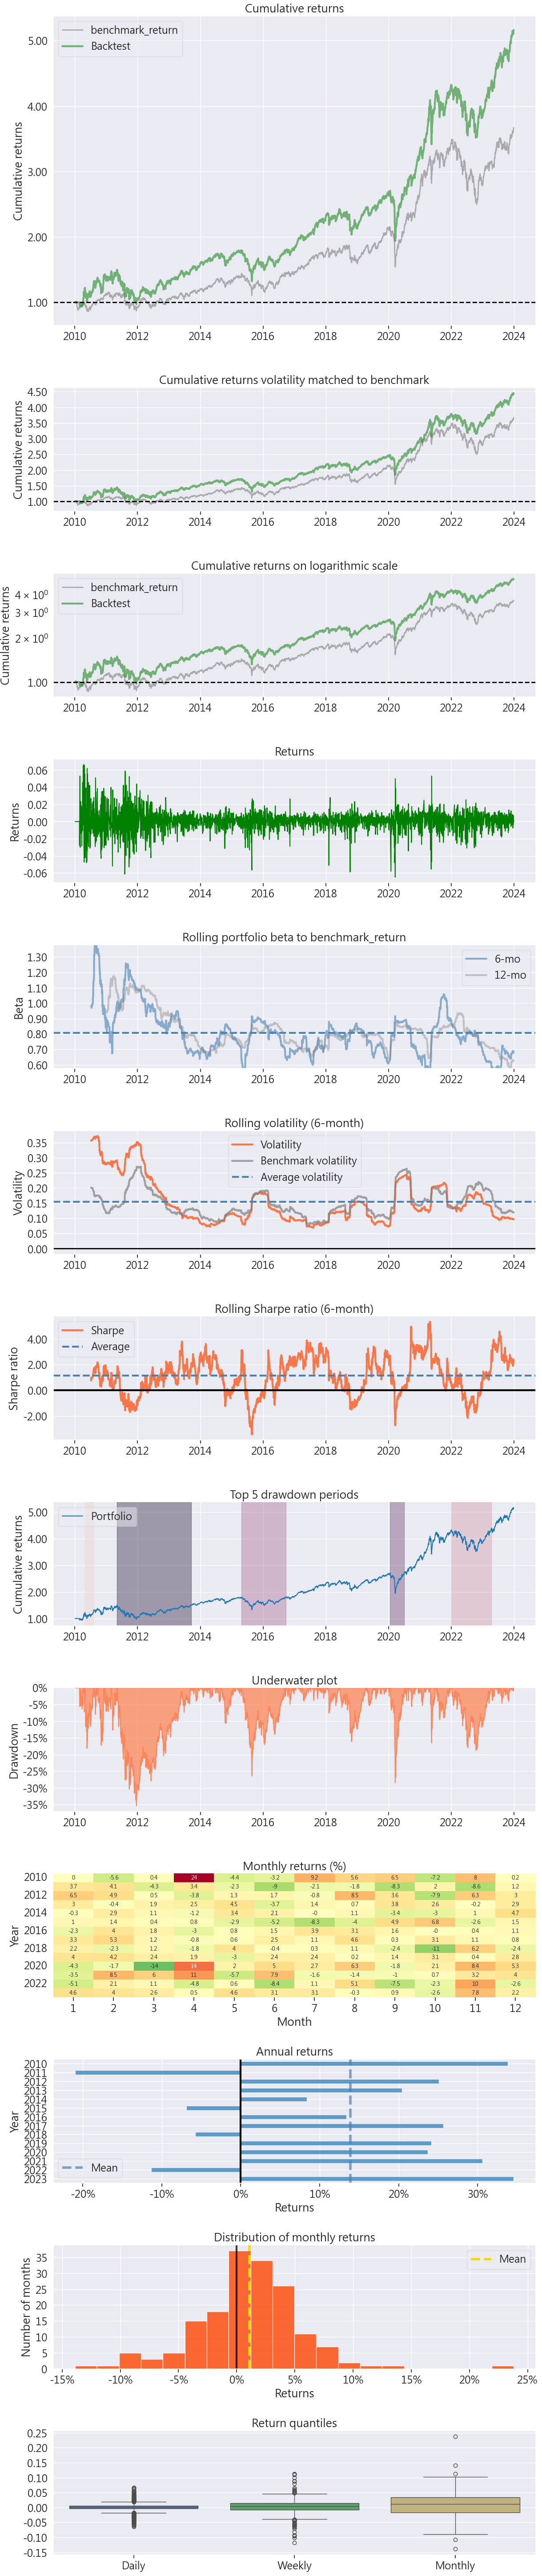

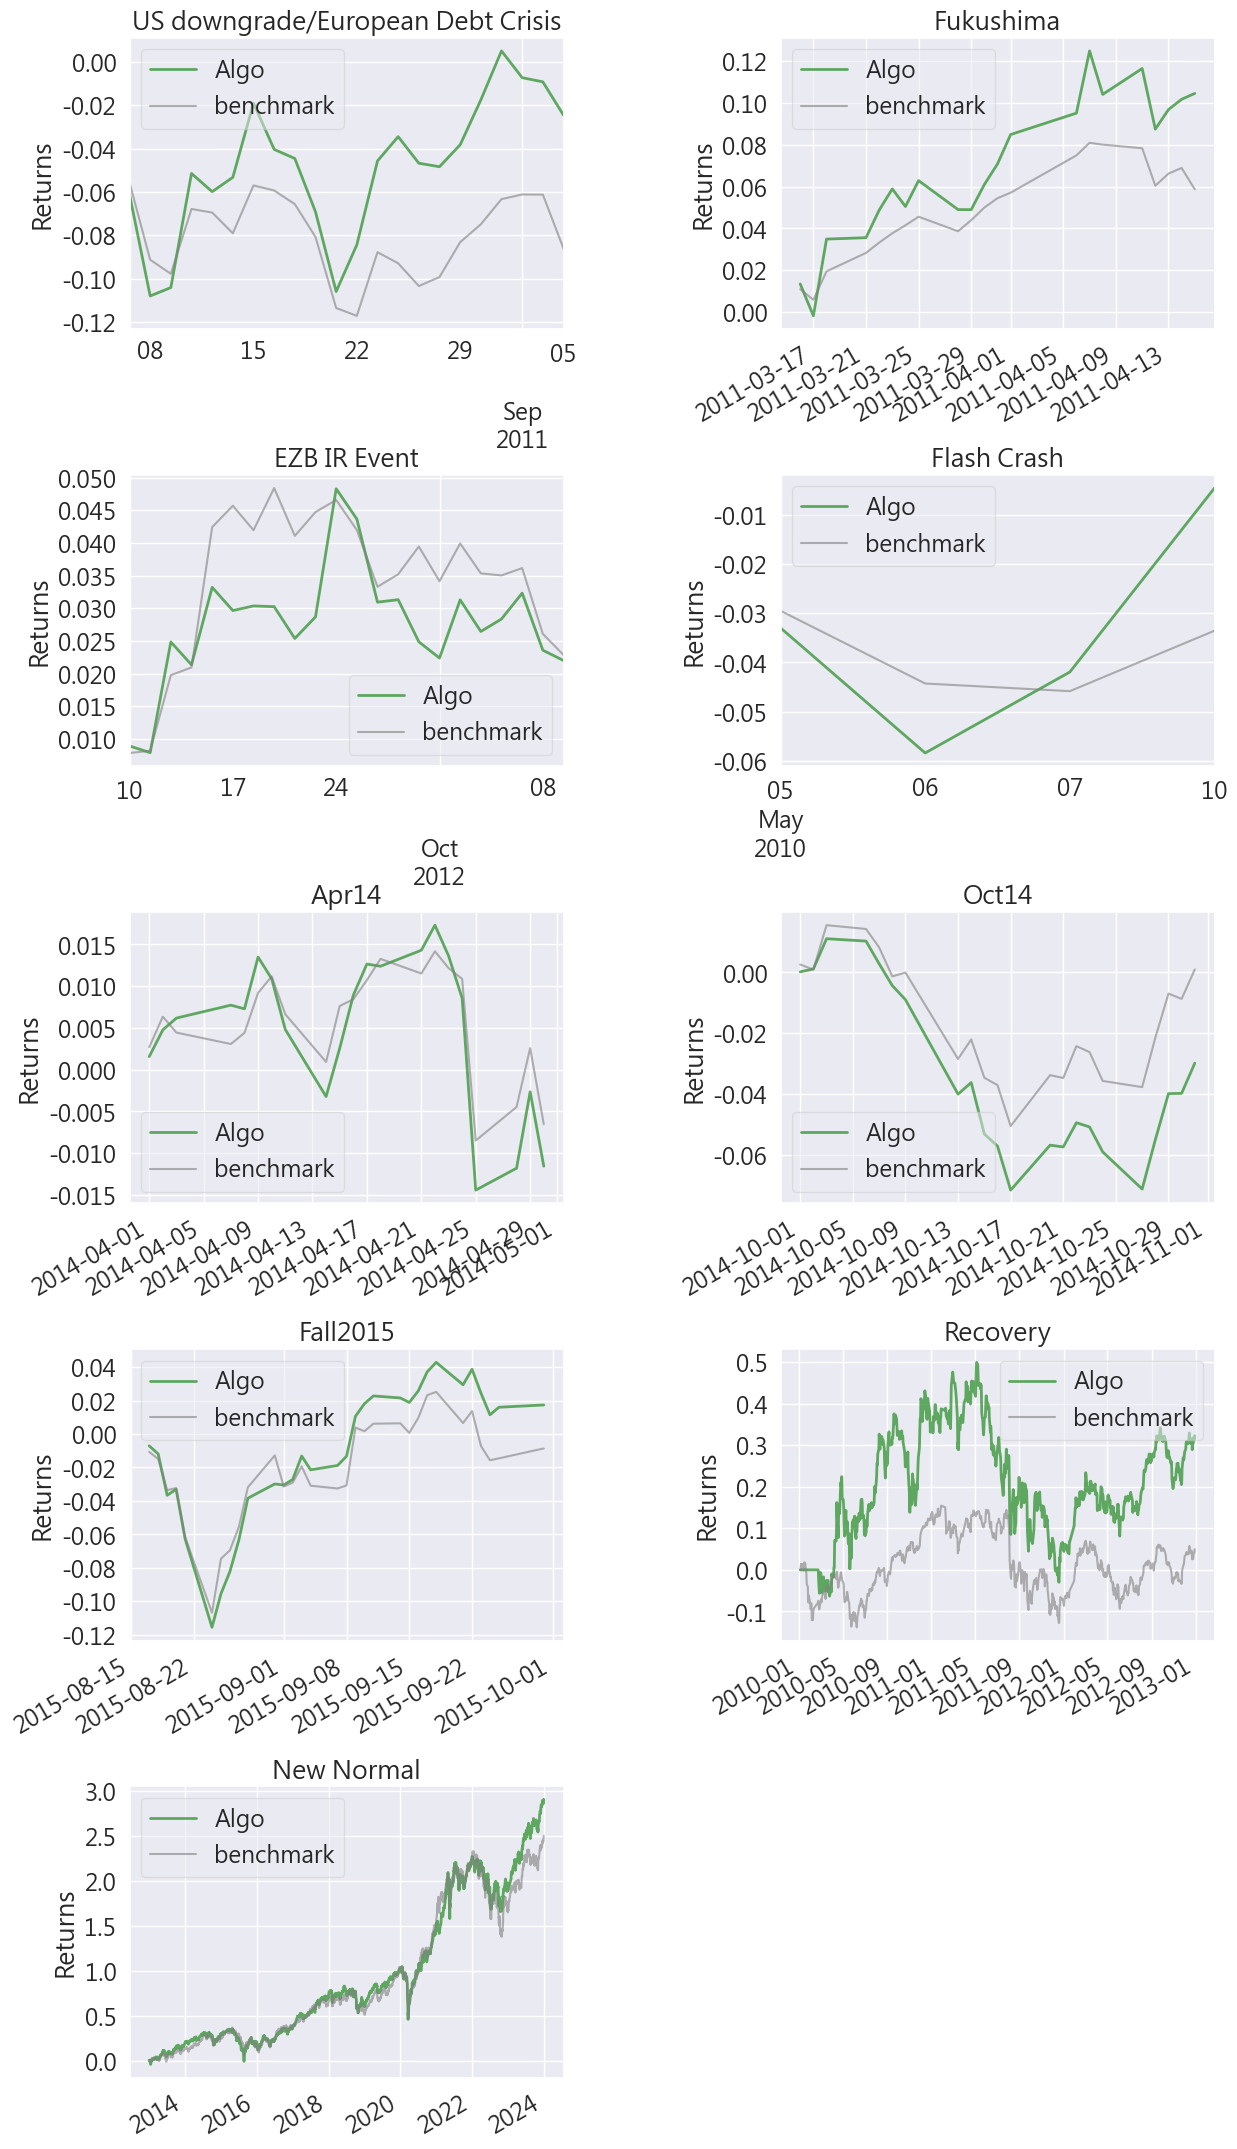

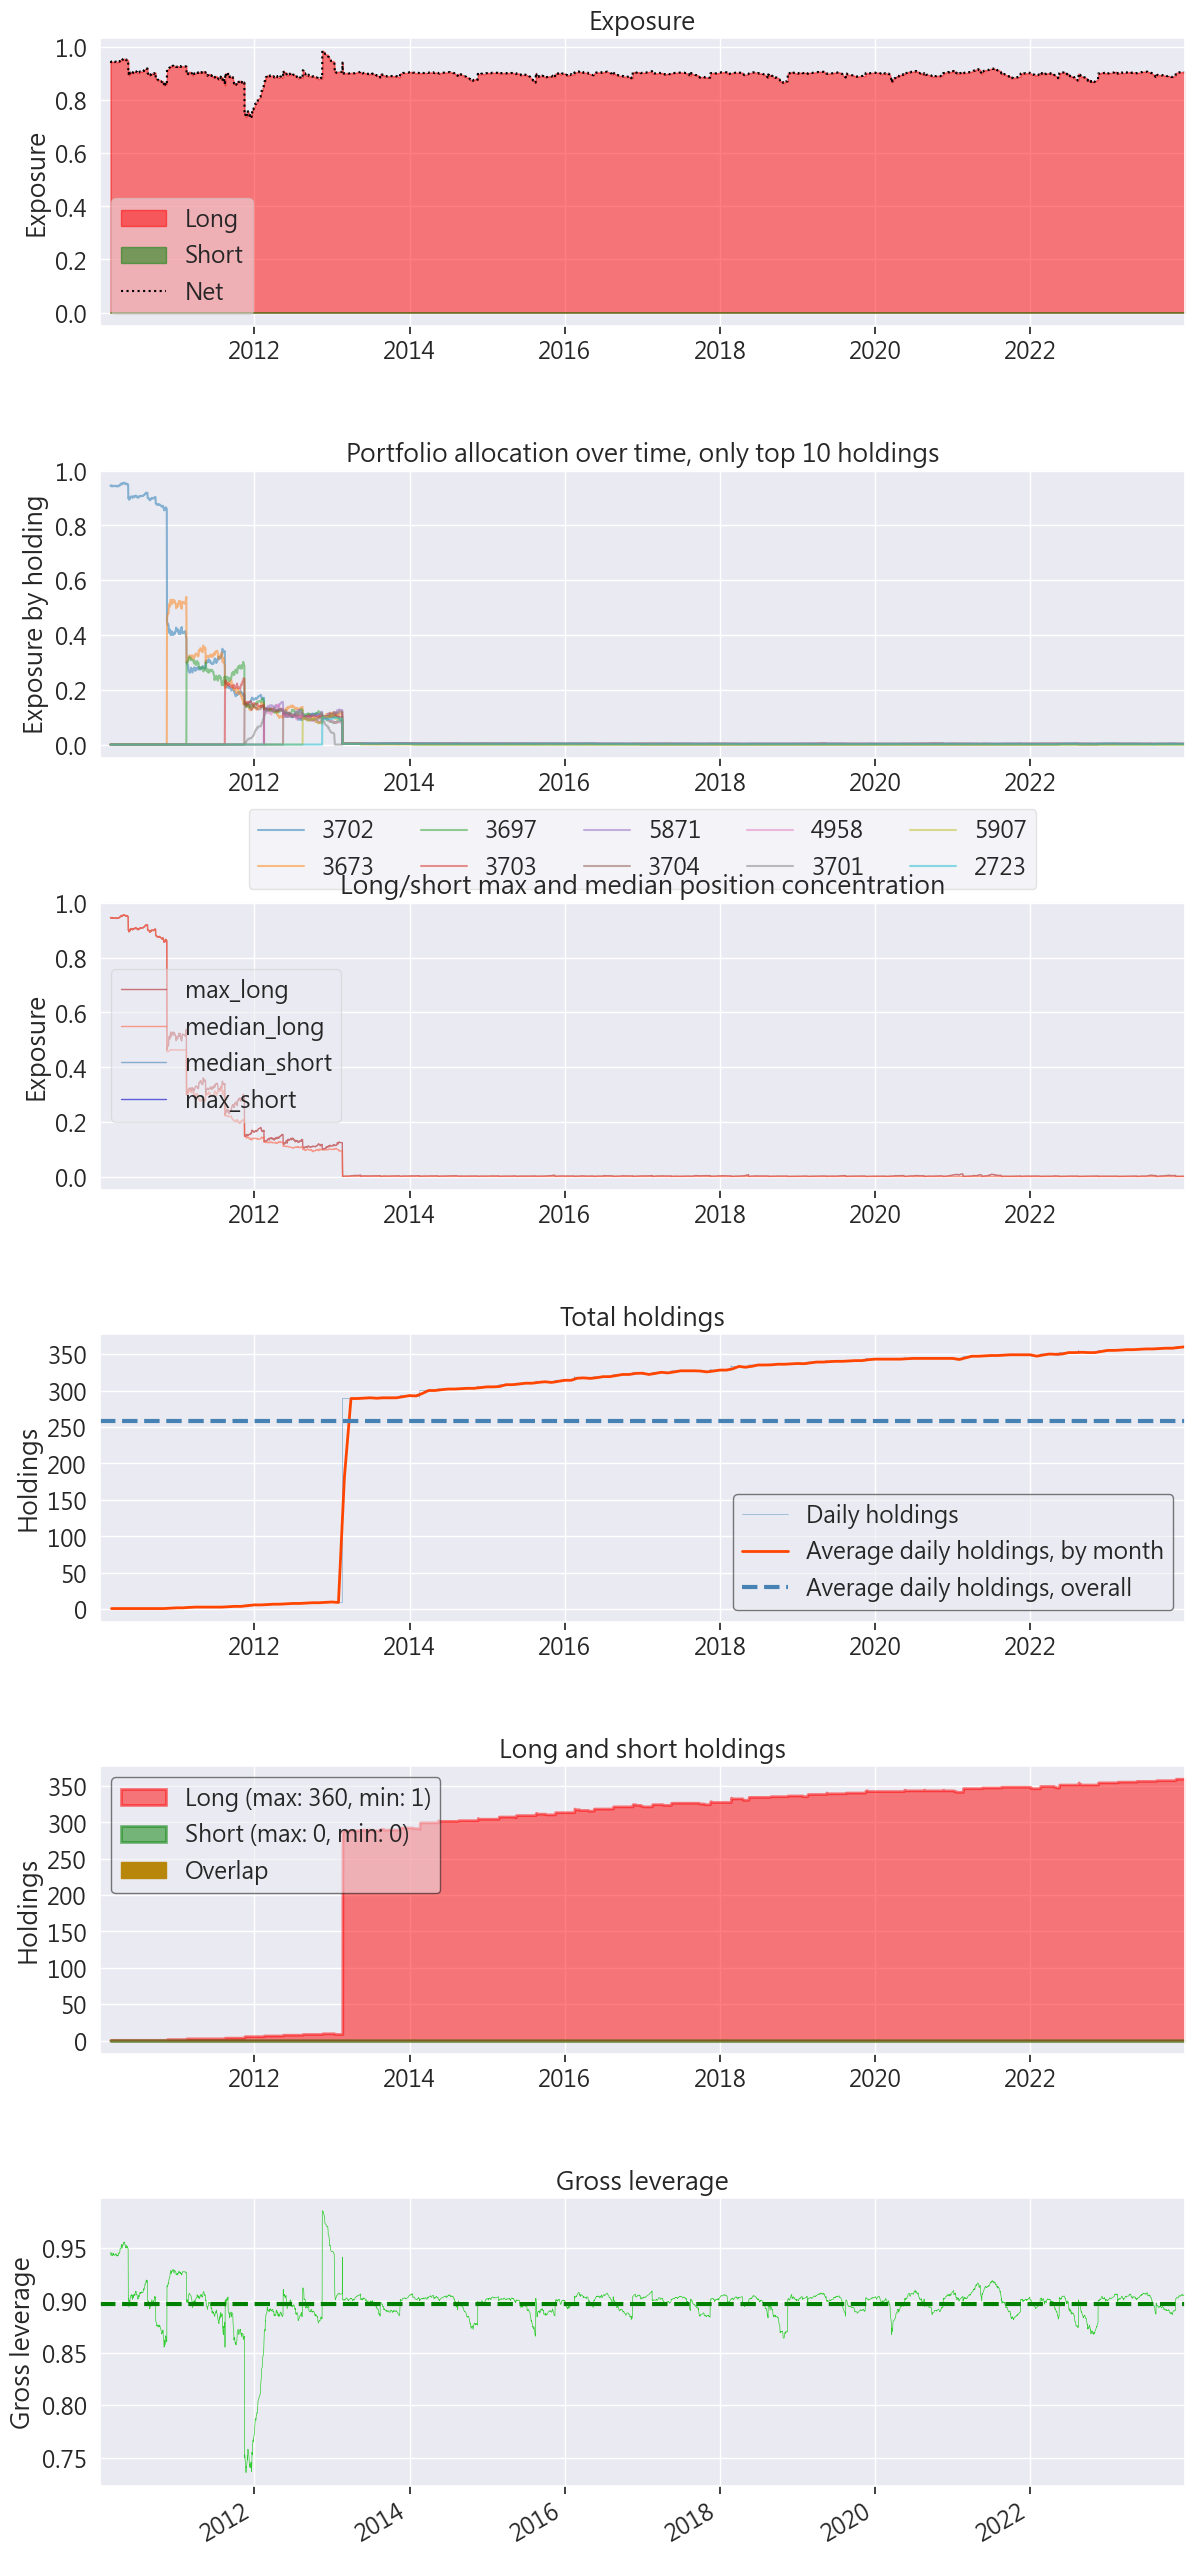

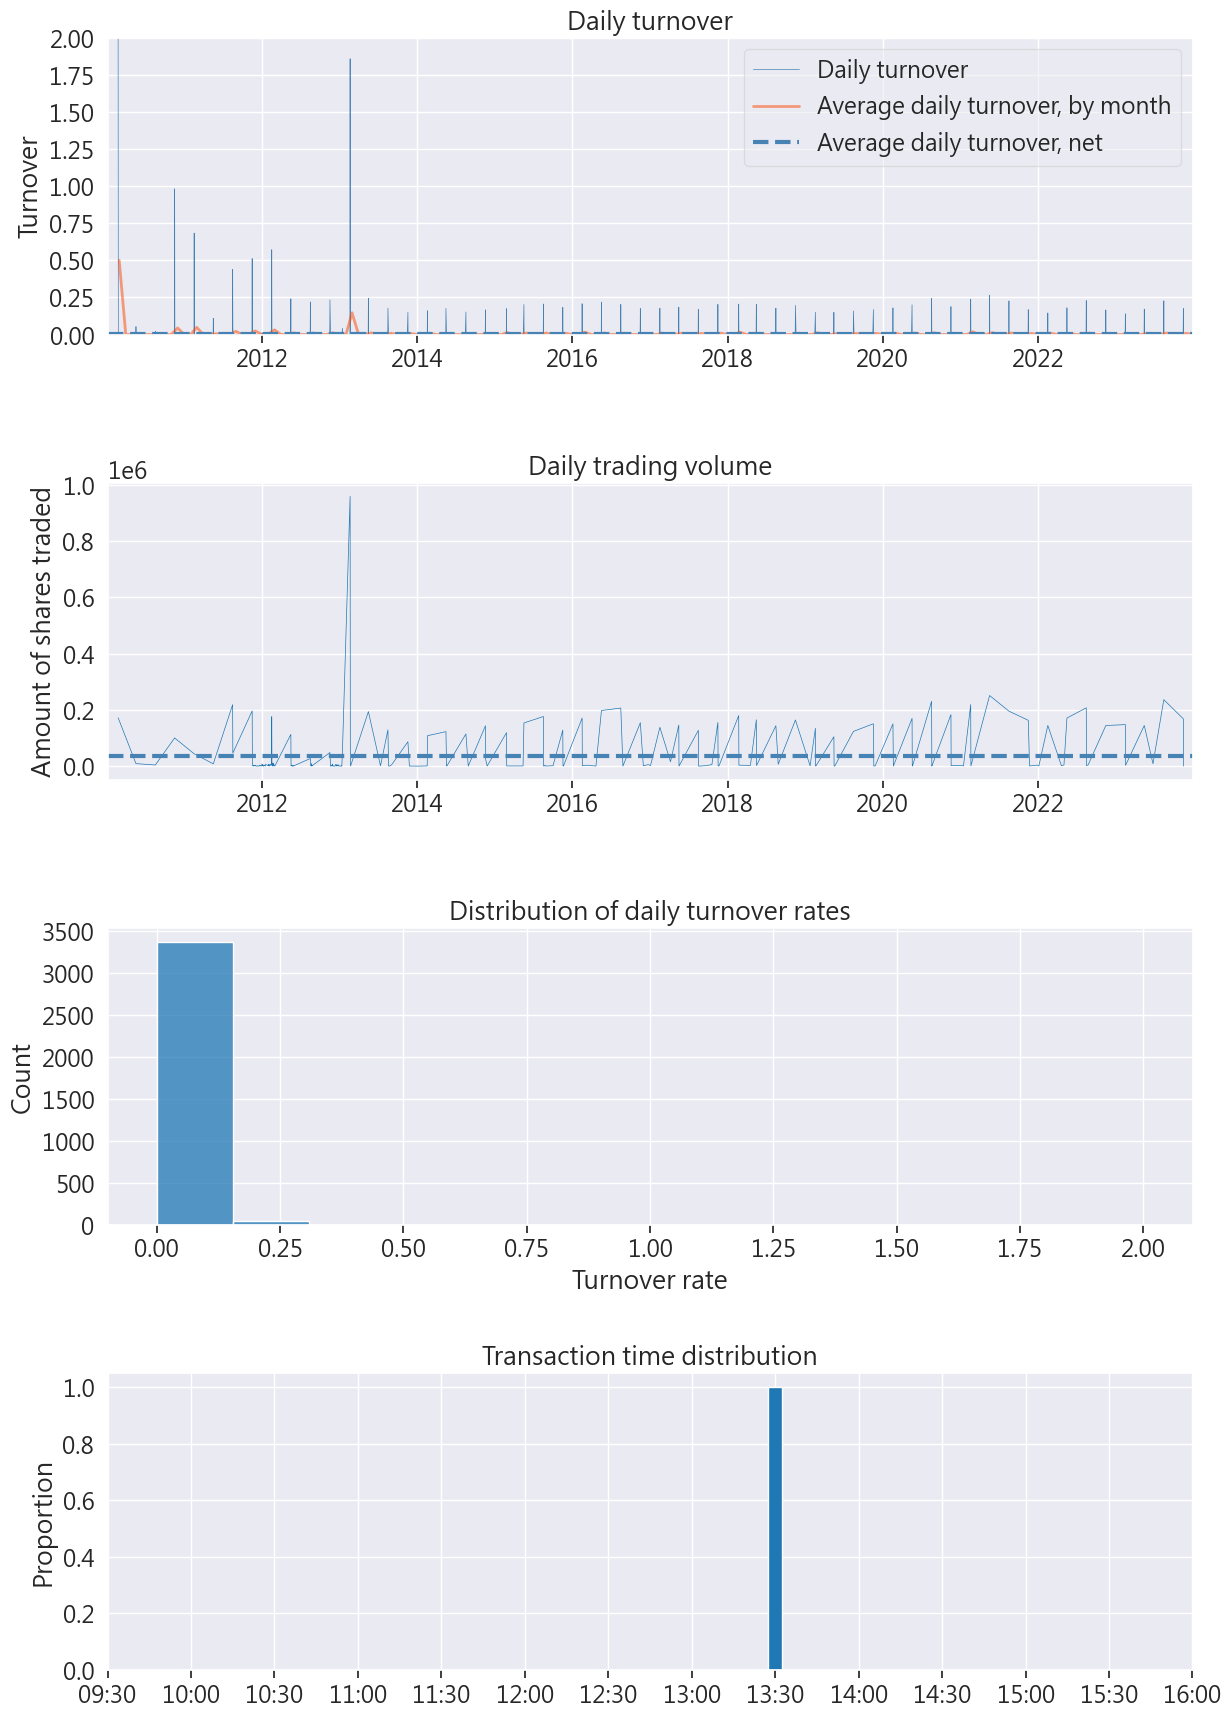

In [24]:
# Extract from the backtest results of Zipline and generate a comprehensive analysis of the portfolio.
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)
benchmark_rets = results['benchmark_return']

pf.tears.create_full_tear_sheet(returns=returns,
                                positions=positions,
                                transactions=transactions,
                                benchmark_rets=benchmark_rets
                                )